In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import argparse
from PIL import Image
from scipy.ndimage import rotate, gaussian_filter, shift

data = torch.load("../data/dataset_155.pt")
nf = data['near_fields']
num_bins = 100

/tmp/ipykernel_113763/2024527050.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../data/dataset_155.pt")


In [2]:
def circular_emd(hist1_weights, hist2_weights):
    """
    Calculates the Earth Mover's Distance for circular histograms.

    It computes the linear EMD for all possible circular shifts of hist2
    and returns the minimum EMD value found. This correctly handles the
    "wrap-around" boundary effect for periodic data like phase angles.
    """
    if hist1_weights.shape != hist2_weights.shape:
        raise ValueError("Histograms must have the same shape")
        
    num_bins = len(hist1_weights)
    bin_indices = np.arange(num_bins)
    
    emd_values = []
    # Iterate through all possible circular shifts
    for s in range(num_bins):
        # Circularly shift the second histogram's weights
        hist2_shifted = np.roll(hist2_weights, shift=s)
        
        # Calculate the standard linear EMD for this shift
        current_emd = wasserstein_distance(
            u_values=bin_indices,
            v_values=bin_indices,
            u_weights=hist1_weights,
            v_weights=hist2_shifted
        )
        emd_values.append(current_emd)
    
    # The circular EMD is the minimum of all calculated EMDs
    return np.min(emd_values)

def get_phase_profile(field_k, phase_bin_edges, num_bins):
    """
    Computes a 1D magnitude-weighted phase profile of a k-space field.
    """
    magnitudes = torch.abs(field_k)
    phases = torch.angle(field_k)
    
    phase_hist = torch.zeros(num_bins, device=field_k.device)
    for i in range(num_bins):
        # mask for all pixels whose phase falls in the current bin
        mask = (phases >= phase_bin_edges[i]) & (phases < phase_bin_edges[i+1])
        phase_hist[i] = torch.sum(magnitudes * mask)
    epsilon = 1e-8
    phase_hist_norm = phase_hist / (torch.sum(phase_hist) + epsilon)
    return phase_hist_norm

def get_radial_profile(field, rho, radial_bin_edges, num_bins):
    """Computes 1D radial profiles (annular binning) of an input field.
    
    Parameters
    ----------
    field (torch.tensor): Input field of shape [xdim, ydim]
    rho (torch.tensor): Polar rho component
    radial_bin_edges (torch.tensor): binning setup
    num_bins (int): number of bins for the radial profiling.
    """
    H, W = field.shape
    
    # 1. Get spatial amplitude map
    magnitude_maps = torch.abs(field)
    
    # Ensure DC is at center for coordinate calculations:
    mag_maps_shifted = torch.fft.fftshift(magnitude_maps, dim=(-2, -1))
    
    radial_hist = torch.zeros(num_bins, device=field.device)    
    for i in range(num_bins):
        mask = (rho >= radial_bin_edges[i]) & (rho < radial_bin_edges[i+1])
        # summing over (H,W) dims
        radial_hist[i] = torch.sum(mag_maps_shifted * mask, dim=(-2,-1))

    # Normalize
    epsilon = 1e-10
    radial_hist_norm = radial_hist / (torch.sum(radial_hist) + epsilon)
    return radial_hist_norm

def get_angular_profile(field, theta, angle_bin_edges, num_bins):
    """Computes 1D angular profiles of an input field.
    
    Parameters
    ----------
    field (torch.tensor): Input field of shape [xdim, ydim]
    theta (torch.tensor): Polar theta component
    angle_bin_edges (torch.tensor): binning setup
    num_bins (int): number of bins for the angular profiling.
    """
    H, W = field.shape
    
    # 1. Get spatial amplitude map
    magnitude_maps = torch.abs(field)
    
    # Ensure DC is at center for coordinate calculations:
    mag_maps_shifted = torch.fft.fftshift(magnitude_maps, dim=(-2, -1))
    
    angle_hist = torch.zeros(num_bins, device=field.device)
    for i in range(num_bins):
        if i == num_bins - 1:
            mask_angle = (theta >= angle_bin_edges[i]) & (theta <= angle_bin_edges[i+1])
        else:
            mask_angle = (theta >= angle_bin_edges[i]) & (theta < angle_bin_edges[i+1])
        angle_hist[i] = torch.sum(mag_maps_shifted * mask_angle, dim=(-1, -2))
    
    # Normalize
    epsilon = 1e-10
    angle_hist_norm = angle_hist / (torch.sum(angle_hist) + epsilon)
    return angle_hist_norm

def precompute_polar_coordinates(H, W, device):
    y = torch.arange(0, H, device=device, dtype=torch.float32)
    x = torch.arange(0, W, device=device, dtype=torch.float32)
    y_indices, x_indices = torch.meshgrid(y, x, indexing='ij')
    crow, ccol = H // 2, W // 2
    x_coords = x_indices - ccol
    y_coords = y_indices - crow
    rho = torch.sqrt(x_coords**2 + y_coords**2) # (H, W)
    theta = (torch.arctan2(y_coords, x_coords) * 180 / torch.pi) % 360 # (H, W)
    return rho, theta

In [3]:
def mse(field1, field2):
    return torch.mean(torch.abs(field1 - field2)**2)

def kMag(field1, field2):
    """k-space magnitude loss. Calculates MSE between magnitudes of k-space fields"""
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    mag_f1_k = torch.abs(field1_k)
    mag_f2_k = torch.abs(field2_k)
    values1 = torch.log1p(mag_f1_k)
    values2 = torch.log1p(mag_f2_k)
    values1_np = values1.flatten().detach().cpu().numpy()
    values2_np = values2.flatten().detach().cpu().numpy()
    return wasserstein_distance(values1_np, values2_np)

def kPhase(field1, field2):
    """k-space phase loss. Calculates MSE of wrapped phase difference between fields"""
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    '''phase_f1_k = torch.angle(field1_k)
    phase_f2_k = torch.angle(field2_k)
    values1 = phase_f1_k.flatten().detach().cpu().numpy()
    values2 = phase_f2_k.flatten().detach().cpu().numpy()
    # normalize weights
    weights1 = (torch.abs(field1_k)).flatten().detach().cpu().numpy()
    weights1_norm = weights1 / (weights1.sum() + 1e-8)
    
    weights2 = (torch.abs(field2_k)).flatten().detach().cpu().numpy()
    weights2_norm = weights2 / (weights2.sum() + 1e-8)'''
    
    phase_bin_edges = torch.linspace(-torch.pi, torch.pi, num_bins+1, device=field1_k.device)
    f1_profile = get_phase_profile(field1, phase_bin_edges, num_bins)
    f2_profile = get_phase_profile(field2, phase_bin_edges, num_bins)
    
    '''emd = wasserstein_distance(
        u_values=bin_indices,
        v_values=bin_indices,
        u_weights=f1_profile.detach().cpu().numpy(),
        v_weights=f2_profile.detach().cpu().numpy()
    )'''
    emd = circular_emd(f1_profile, f2_profile)
    return emd

def kRadial(field1, field2):
    """k-space radial loss. Returns the MSE of radial profiles (annular binning) between fields"""
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    h, w = field1_k.shape
    radial_bin_edges = torch.linspace(0, torch.hypot(torch.tensor(h/2), torch.tensor(w/2)).item(), num_bins + 1, device=field1_k.device)
    rho, _ = precompute_polar_coordinates(h, w, field1_k.device)
    f1_k_radial = get_radial_profile(field1_k, rho, radial_bin_edges, num_bins)
    f2_k_radial = get_radial_profile(field2_k, rho, radial_bin_edges, num_bins)
    bin_indices = np.arange(num_bins)
    emd = wasserstein_distance(
        u_values=bin_indices,
        v_values=bin_indices,
        u_weights=f1_k_radial.detach().cpu().numpy(),
        v_weights=f2_k_radial.detach().cpu().numpy()
    )
    return emd

def kAngular(field1, field2):
    """k-space angular loss. Returns the MSE of angular profiles between fields."""
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    h, w = field1_k.shape
    angle_bin_edges = torch.linspace(0, 360, num_bins + 1, device=field1_k.device)
    _, theta = precompute_polar_coordinates(h, w, field1_k.device)
    f1_k_angular = get_angular_profile(field1_k, theta, angle_bin_edges, num_bins)
    f2_k_angular = get_angular_profile(field2_k, theta, angle_bin_edges, num_bins)
    bin_indices = np.arange(num_bins)
    '''emd = wasserstein_distance(
        u_values=bin_indices,
        v_values=bin_indices,
        u_weights=f1_k_angular.detach().cpu().numpy(),
        v_weights=f2_k_angular.detach().cpu().numpy()
    )'''
    emd = circular_emd(f1_k_angular, f2_k_angular)
    return emd
    
def aggregate(field1, field2):
    # sort of redundant but good for udnerstanding all contributions
    tensor = torch.tensor((1*(kMag(field1, field2)),
                      1*(kPhase(field1, field2)), 
                      1*(kRadial(field1, field2)), 
                      1*(kAngular(field1, field2))))
    return torch.mean(tensor)

In [45]:
def plot_delta_field_dissimilarity(metrics, field_volume, method="grow"):
    """Plots field slice similarity across a larger field volume with various metrics
    
    Parameters
    ----------
    metrics (List): A list of functions
    field_volume (torch.Tensor): The full (2, 166, 166, 63) field volume (two fields)
    method (str) (Optional): Type of measurement. 'grow' or 'sliding' supported
    """
    real = field_volume[0]
    imag = field_volume[1]
    fields = torch.complex(real, imag) # [166,166,63]
    fields = normalize_fields(fields)
    
    # iterate through to get the values
    for func in metrics:
        vals = []
        if method == "grow":
            for i in range(fields.shape[-1]):
                vals.append(func(fields[:, :, 0], fields[:, :, i]))
        elif method == "sliding":
            for i in range(fields.shape[-1] - 1):
                vals.append(func(fields[:, :, i], fields[:, :, i+1]))
        vals = np.array(vals)
        vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
        plt.plot(vals, label=func.__name__)
     
    # plot specs    
    plt.title(f"normalized field volume similarity - method: {method}")
    if method == "grow":
        plt.xlabel("Distance - Increasing")
    else:
        plt.xlabel("Distance - Sliding")
    plt.ylabel("Metric Value - k-metric EMD")
    plt.legend()
    plt.savefig(f'../results/emd_plots/sim-{method}.pdf')
    #plt.close()
    plt.show()
    
    '''fig, axes = plt.subplots(2, 5, figsize=(20, 5))
    
    for i in range(5):
        ax = axes[0][i]
        field1_k = torch.fft.fft2(fields[:, :, i+13], norm="ortho")
        phase_f1_k = torch.angle(field1_k)
        ax.imshow(phase_f1_k, cmap='gray')
        ax.set_title(f"Slice {i+13}")
        ax.axis('off')
        ax = axes[1][i]
        field2_k = torch.fft.fft2(fields[:, :, i+14], norm="ortho")
        phase_f2_k = torch.angle(field2_k)
        ax.imshow(phase_f2_k, cmap='gray')
        ax.set_title(f"Slice {i+14}")
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"emd_plots/debug_kphase_{method}.png")'''
    
def plot_metrics_for_augments(metrics, slice):
    image = slice[0] # real component
    image_np = image.detach().cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    
    # translation
    # periodic translation
    shift_vector = [-10, 15] # [dy, dx]
    translated_image_np = shift(image_np, shift_vector, mode='wrap')
    
    # rotation
    rotated_image_np = rotate(image_np, angle=90, reshape=False, mode='constant', cval=0.0, order=1)
    
    # blurring
    blurred_image_np = gaussian_filter(image_np, sigma=2.0, mode='constant', cval=0.0)
    
    image_np = torch.from_numpy(image_np)
    
    augments = [translated_image_np, rotated_image_np, blurred_image_np]
    augs = ['translation', 'rotation', 'gaussian blur']
    
    for aug_image, aug_name in zip(augments, augs):
        aug_image = torch.from_numpy(aug_image)
        # Calculate all metrics
        metrics = {
            'MSE': mse(image_np, aug_image),
            'kPhase': kPhase(image_np, aug_image),
            'kRadial': kRadial(image_np, aug_image),
            'kAngular': kAngular(image_np, aug_image)
        }
        metric_names = list(metrics.keys())
        metric_values = list(metrics.values())
        #print(f'metric_values first one before norm: {metric_values[0]}')
        # normalizing
        #max_kR = max(metric_values)
        #print(f'max_kR: {max_kR}')
        #metric_values = [val / max_kR for val in metric_values]
        #print(f'metric_values first one after norm: {metric_values[0]}')

        # Create the plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1.5]})
        
        
        # Plot Original Image
        ax = axes[0]
        ax.imshow(image_np, cmap='gray')
        ax.set_title("Original Image")
        ax.axis('off')

        # Plot Modified Image
        ax = axes[1]
        ax.imshow(aug_image, cmap='gray')
        ax.set_title("Modified Image")
        ax.axis('off')

        # Plot Bar Chart of Metrics
        ax = axes[2]
        bars = ax.bar(metric_names, metric_values, color=['skyblue', 'salmon', 'lightgreen', 'plum'])
        ax.set_title("Similarity Metrics")
        ax.set_ylabel("Metric Value (Dissimilarity)")
        ax.bar_label(bars, fmt='%.4f') # Add values on top of bars

        fig.suptitle(f"Image Comparison: {aug_name}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f"../results/emd_plots/comparison_{aug_name}.png")
        plt.show()


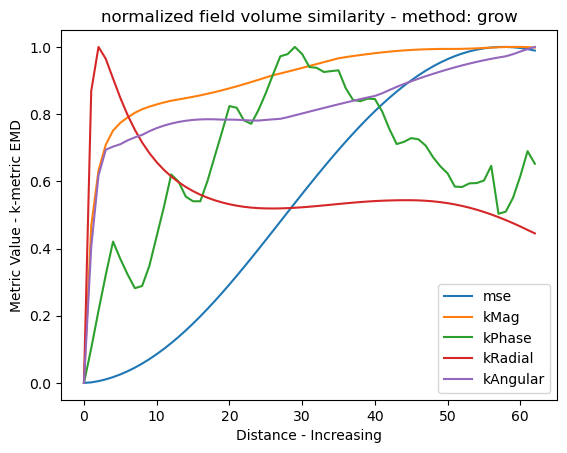

In [48]:
metrics = [mse, kMag, kPhase, kRadial, kAngular]

plot_delta_field_dissimilarity(metrics, nf[0], method='grow')

#plot_metrics_for_augments(metrics, nf[0, :, :, :, 0])

In [15]:
def plot_slice_state(fields, slice_index):
    """
    Creates a 2x2 plot showing the state of a single complex field slice.
    
    Parameters:
    - fields (torch.Tensor): The full [166, 166, 63] complex field volume.
    - slice_index (int): The index of the slice to inspect.
    """
    if not (0 <= slice_index < fields.shape[-1]):
        print(f"Error: slice_index must be between 0 and {fields.shape[-1]-1}")
        return

    slc = fields[:, :, :, slice_index].detach().cpu()
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(f"State Inspector: Slice {slice_index}", fontsize=16)

    # Real Part
    im_real = axes[0, 0].imshow(slc[0], cmap='viridis')
    axes[0, 0].set_title("Real Part")
    fig.colorbar(im_real, ax=axes[0, 0])

    # Imaginary Part
    im_imag = axes[0, 1].imshow(slc[1], cmap='viridis')
    axes[0, 1].set_title("Imaginary Part")
    fig.colorbar(im_imag, ax=axes[0, 1])
    
    # Magnitude
    im_mag = axes[1, 0].imshow(torch.abs(torch.complex(slc[0], slc[1])), cmap='viridis')
    axes[1, 0].set_title("Magnitude")
    fig.colorbar(im_mag, ax=axes[1, 0])

    # Phase
    im_phase = axes[1, 1].imshow(torch.angle(torch.complex(slc[0], slc[1])), cmap='twilight_shifted')
    axes[1, 1].set_title("Phase")
    fig.colorbar(im_phase, ax=axes[1, 1])

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

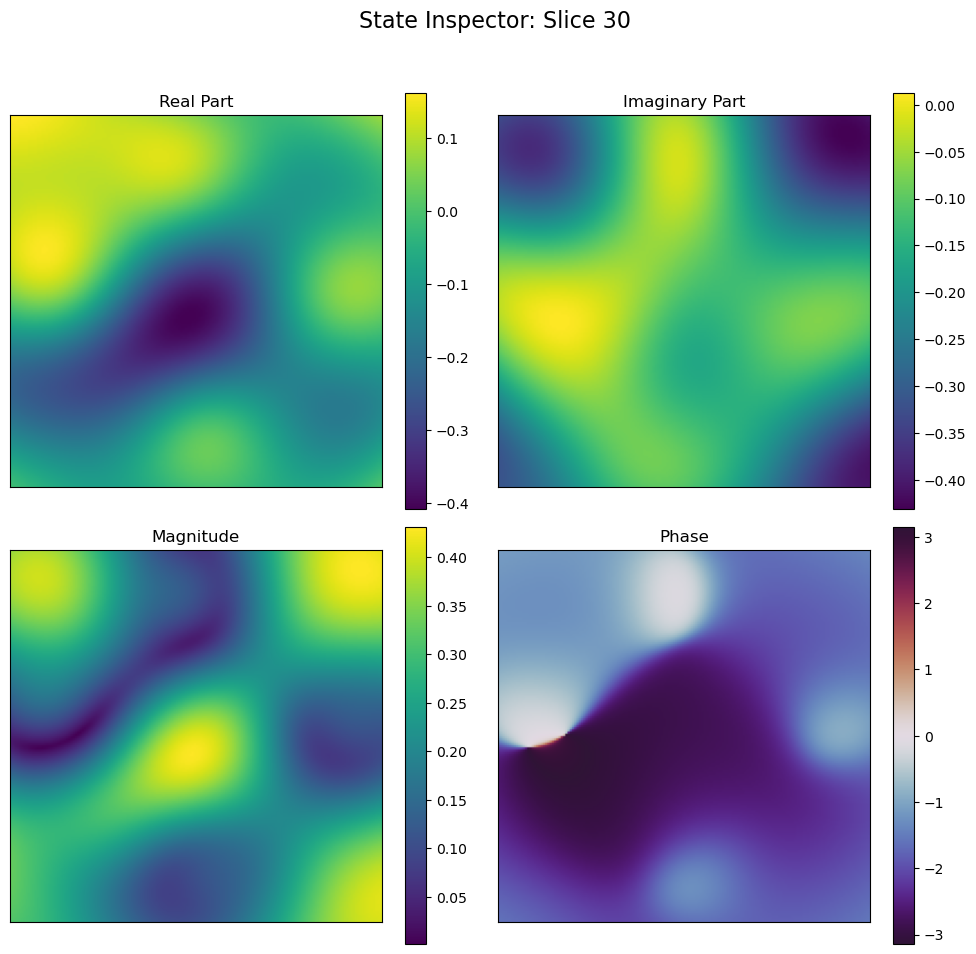

In [16]:
plot_slice_state(nf[10], 30)

In [ ]:
import matplotlib.animation as animation

def animate_metric_sync(fields, metrics, method="sliding", fixed_scale=False):
    num_steps = fields.shape[-1]
    num_frames = num_steps - 1 if method == "sliding" else num_steps
    
    # convert to complex
    fields = torch.complex(fields[0], fields[1])
    fields = normalize_fields(fields)

    # --- Step 1: Pre-calculate all metric values ---
    print("Pre-calculating metric values...")
    metric_data = {}
    for func in metrics:
        vals = []
        if method == "grow":
            for i in range(num_steps):
                vals.append(func(fields[:, :, 0], fields[:, :, i]))
        elif method == "sliding":
            for i in range(num_steps - 1):
                vals.append(func(fields[:, :, i], fields[:, :, i + 1]))
        
        vals = np.array(vals)
        metric_data[func.__name__] = (vals - np.min(vals)) / (np.max(vals) - np.min(vals) + 1e-10)
    
    # --- NEW: Pre-calculate global max for fixed scale ---
    global_vmax = 1.0 # Default value
    if fixed_scale:
        print("Calculating global max for fixed color scale...")
        max_val = 0
        for frame in range(num_frames):
            if method == "sliding":
                current_diff = fields[:, :, frame + 1] - fields[:, :, frame]
            else: # grow
                current_diff = fields[:, :, frame] - fields[:, :, 0]
            frame_max = torch.abs(current_diff).max().item()
            if frame_max > max_val:
                max_val = frame_max
        global_vmax = max_val
    
    print("Calculation complete. Starting animation rendering.")
    
    # --- Step 2: Set up the plot layout ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 2]})
    
    # --- Panel 1: The Difference Image ---
    if method == "sliding":
        diff_field = fields[:, :, 1] - fields[:, :, 0]
        title_text = "Difference (Slice {i_plus_1} - Slice {i})"
    else: # grow
        diff_field = fields[:, :, 0] - fields[:, :, 0]
        title_text = "Difference (Slice {i} - Slice 0)"
    
    diff_mag = torch.abs(diff_field).detach().cpu()
    
    # Set initial vmin/vmax for the image
    vmin = 0
    vmax = global_vmax if fixed_scale else (diff_mag.max().item() if diff_mag.max() > 0 else 1.0)
    im = ax1.imshow(diff_mag, cmap='viridis', animated=True, vmin=vmin, vmax=vmax)
    ax1.set_xticks([]); ax1.set_yticks([])
    fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

    # --- Panel 2: The Metric Line Graph ---
    # ... (this part is unchanged)
    for name, data in metric_data.items():
        ax2.plot(data, label=name, alpha=0.7)
    vline = ax2.axvline(0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlim(0, num_frames - 1); ax2.set_ylim(-0.1, 1.1)
    ax2.set_title("Normalized Metric Values"); ax2.set_xlabel("Step"); ax2.set_ylabel("Normalized Dissimilarity")
    ax2.legend(); ax2.grid(True, alpha=0.5)

    # --- Step 3: Define the animation update function ---
    def update(frame):
        # Update the difference image (ax1)
        if method == "sliding":
            current_diff = fields[:, :, frame + 1] - fields[:, :, frame]
            ax1.set_title(title_text.format(i_plus_1=frame + 1, i=frame))
        else: # grow
            current_diff = fields[:, :, frame] - fields[:, :, 0]
            ax1.set_title(title_text.format(i=frame))
        
        diff_mag = torch.abs(current_diff).detach().cpu()
        im.set_data(diff_mag)
        
        # --- MODIFIED: Only update clim if not using fixed scale ---
        if not fixed_scale:
            im.set_clim(vmin=diff_mag.min(), vmax=diff_mag.max())

        # Update the tracker line (ax2)
        vline.set_xdata([frame])
        
        return [im, vline]

    # --- Step 4: Create and save the animation ---
    ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True, interval=100)
    
    save_filename = f'../results/emd_plots/metric_sync_animation_{method}_{"fixed" if fixed_scale else "dynamic"}.mp4'
    ani.save(save_filename, writer='ffmpeg', dpi=150)
    print(f"Animation saved to {save_filename}")
    plt.close()

In [51]:
animate_metric_sync(nf[0], metrics, method="grow", fixed_scale=True)

Pre-calculating metric values...
Calculating global max for fixed color scale...
Calculation complete. Starting animation rendering.
Animation saved to ../results/emd_plots/metric_sync_animation_grow_fixed.mp4


In [66]:
def animate_dashboard(fields, metrics, method='sliding', plot_property='magntiude', fixed_scale=False):
    """
    Creates a multi-panel dashboard animation showing the real-space magnitude,
    k-space magnitude (power spectrum), and the metric graph evolving in sync.
    """
    # --- Step 0: Prepare Data ---
    fields_complex = torch.complex(fields[0], fields[1])
    fields_complex = normalize_fields(fields_complex)
    num_steps = fields_complex.shape[-1]
    num_frames = num_steps - 1 if method == "sliding" else num_steps

    if plot_property not in ['magnitude', 'phase']:
        raise ValueError("plot_property must be 'magnitude' or 'phase'")

    cmap = 'viridis' if plot_property == 'magnitude' else 'twilight_shifted'

    # --- Step 1: Pre-calculate metric values ---
    print("Pre-calculating metric values...")
    metric_data = {}
    for func in metrics:
        vals = []
        if method == "grow":
            for i in range(num_frames):
                vals.append(func(fields_complex[:, :, 0], fields_complex[:, :, i]))
        else: # sliding
            for i in range(num_frames):
                vals.append(func(fields_complex[:, :, i], fields_complex[:, :, i + 1]))
        vals = np.array(vals)
        metric_data[func.__name__] = (vals - np.min(vals)) / (np.max(vals) - np.min(vals) + 1e-10)
    
    # --- Step 2: Pre-calculate global max for fixed scale ---
    raw_vmax, diff_vmax = 1.0, 1.0
    if fixed_scale:
        print("Calculating global max for fixed color scale...")
        raw_max_val, diff_max_val = 0, 0
        for frame in range(num_frames):
            if method == "sliding":
                raw_field = fields_complex[:, :, frame + 1]
                diff_field = fields_complex[:, :, frame + 1] - fields_complex[:, :, frame]
            else: # grow
                raw_field = fields_complex[:, :, frame]
                diff_field = fields_complex[:, :, frame] - fields_complex[:, :, 0]
            
            prop_func = torch.abs if plot_property == 'magnitude' else torch.angle
            raw_max_val = max(raw_max_val, prop_func(raw_field).max().item())
            diff_max_val = max(diff_max_val, prop_func(diff_field).max().item())
        raw_vmax, diff_vmax = raw_max_val, diff_max_val

    print("Calculation complete. Starting animation rendering.")

    # --- Step 3: Set up the plot layout ---
    fig = plt.figure(figsize=(12, 10))
    ax_raw = plt.subplot(2, 2, 1)
    ax_diff = plt.subplot(2, 2, 2)
    ax_metrics = plt.subplot(2, 1, 2)
    
    # --- Panel 1: Raw Field ---
    prop_func = torch.abs if plot_property == 'magnitude' else torch.angle
    raw_data = prop_func(fields_complex[:, :, 0]).detach().cpu()
    im_raw = ax_raw.imshow(raw_data, cmap=cmap, vmin=0, vmax=raw_vmax if fixed_scale else raw_data.max())
    ax_raw.set_title("Raw Field Evolution")
    ax_raw.set_xticks([]); ax_raw.set_yticks([])
    fig.colorbar(im_raw, ax=ax_raw, fraction=0.046, pad=0.04)

    # --- Panel 2: Difference Field ---
    if method == 'sliding':
        diff_data = prop_func(fields_complex[:,:,1] - fields_complex[:,:,0]).detach().cpu()
    else:
        diff_data = torch.zeros_like(raw_data) # Starts at zero
    im_diff = ax_diff.imshow(diff_data, cmap=cmap, vmin=0, vmax=diff_vmax if fixed_scale else diff_data.max())
    ax_diff.set_title("Difference Field")
    ax_diff.set_xticks([]); ax_diff.set_yticks([])
    fig.colorbar(im_diff, ax=ax_diff, fraction=0.046, pad=0.04)
    
    # --- Panel 3: Metric Line Graph (unchanged) ---
    for name, data in metric_data.items():
        ax_metrics.plot(data, label=name, alpha=0.7)
    vline = ax_metrics.axvline(0, color='red', linestyle='--', linewidth=2)
    ax_metrics.set_xlim(0, num_frames - 1); ax_metrics.set_ylim(-0.1, 1.1)
    ax_metrics.set_title("Normalized Metric Values"); ax_metrics.set_xlabel(f"Distance from Slice 0")
    ax_metrics.legend(); ax_metrics.grid(True, alpha=0.5)

    # --- Step 4: Define the animation update function ---
    def update(frame):
        # Determine which slices to show/compare for this frame
        if method == "sliding":
            raw_field = fields_complex[:, :, frame + 1]
            diff_field = fields_complex[:, :, frame + 1] - fields_complex[:, :, frame]
            raw_title = f"Raw Field (Slice {frame+1})"
            diff_title = f"Difference (Slice {frame+1} - {frame})"
        else: # grow
            raw_field = fields_complex[:, :, frame]
            diff_field = fields_complex[:, :, frame] - fields_complex[:, :, 0]
            raw_title = f"Raw Field (Slice {frame})"
            diff_title = f"Difference (Slice {frame} - 0)"

        prop_func = torch.abs if plot_property == 'magnitude' else torch.angle
        
        # Update raw field panel
        raw_data = prop_func(raw_field).detach().cpu()
        im_raw.set_data(raw_data)
        if not fixed_scale: im_raw.set_clim(vmin=raw_data.min(), vmax=raw_data.max())
        ax_raw.set_title(raw_title)

        # Update difference field panel
        diff_data = prop_func(diff_field).detach().cpu()
        im_diff.set_data(diff_data)
        if not fixed_scale: im_diff.set_clim(vmin=diff_data.min(), vmax=diff_data.max())
        ax_diff.set_title(diff_title)
        
        # Update tracker line
        vline.set_xdata([frame])
        return [im_raw, im_diff, vline]

    # --- Step 5: Create and save the animation ---
    ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True, interval=150)
    save_filename = f'../results/emd_plots/dashboard_pro_animation_{method}_{plot_property}.mp4'
    ani.save(save_filename, writer='ffmpeg', dpi=150)
    print(f"Animation saved to {save_filename}")
    plt.close()

In [67]:
metrics = [mse, kPhase, kRadial, kAngular]
animate_dashboard(nf[2], metrics, method="grow", plot_property='phase')

Pre-calculating metric values...
Calculation complete. Starting animation rendering.
Animation saved to ../results/emd_plots/dashboard_pro_animation_grow_phase.mp4


In [23]:
def animate_phase_profile(fields, kPhase_func):
    """
    Creates a polar plot animation of the k-space phase profile to visualize
    the kPhase metric.
    """
    num_steps = fields.shape[-1]
    fields = torch.complex(fields[0], fields[1])
    
    # --- Step 1: Pre-calculate the kPhase metric values for the title ---
    print("Pre-calculating kPhase values...")
    kPhase_vals = [kPhase_func(fields[:, :, i], fields[:, :, i + 1]) for i in range(num_steps - 1)]
    kPhase_vals = np.array(kPhase_vals)
    print("Calculation complete. Starting animation rendering.")

    # --- Step 2: Set up the plot layout ---
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    # --- Step 3: Define the animation update function ---
    def update(frame):
        ax.clear() # Clear axis for each new frame

        # Calculate the phase profile for the current frame
        field_k = torch.fft.fft2(fields[:, :, frame], norm="ortho")
        device = field_k.device
        phase_bin_edges = torch.linspace(-np.pi, np.pi, num_bins + 1, device=device)
        phase_profile = get_phase_profile(field_k, phase_bin_edges, num_bins)
        
        # Get bin centers for plotting (-pi to +pi)
        bin_centers = (phase_bin_edges[:-1] + phase_bin_edges[1:]) / 2
        
        # Plot the profile as a filled area
        ax.bar(bin_centers.cpu().numpy(), phase_profile.cpu().numpy(), 
               width=(2 * np.pi / num_bins), alpha=0.7, color='C1') # Use orange color
        
        # Configure the plot to look like a standard unit circle
        ax.set_theta_offset(0) # 0 degrees on the right
        ax.set_theta_direction(1) # Counter-clockwise
        ax.set_rlabel_position(90)
        ax.grid(True, alpha=0.5)
        
        # Set the radial limit to be consistent across frames
        # You may need to adjust the max value based on your data
        ax.set_rlim(0, np.max(phase_profile.cpu().numpy()) * 1.5 + 0.01)

        # Update the title with the metric value for the *next* transition
        if frame < len(kPhase_vals):
            title = f"Slice {frame} -> {frame+1}\nkPhase (Binned) EMD: {kPhase_vals[frame]:.4f}"
        else:
            title = f"Slice {frame}"
        ax.set_title(title, va='bottom')

    # --- Step 4: Create and save the animation ---
    ani = animation.FuncAnimation(fig, update, frames=num_steps - 1, interval=150)
    save_filename = '../results/emd_plots/phase_profile_animation.mp4'
    ani.save(save_filename, writer='ffmpeg', dpi=150)
    print(f"Animation saved to {save_filename}")
    plt.close()

In [24]:
animate_phase_profile(nf[10], kPhase)

Pre-calculating kPhase values...
Calculation complete. Starting animation rendering.
Animation saved to ../results/emd_plots/phase_profile_animation.mp4


In [25]:
def circular_emd_with_shift(hist1_weights, hist2_weights):
    """
    Calculates the circular EMD and the optimal shift that achieves it.
    """
    num_bins = len(hist1_weights)
    bin_indices = np.arange(num_bins)
    
    emd_values = []
    for s in range(num_bins):
        hist2_shifted = np.roll(hist2_weights, shift=s)
        current_emd = wasserstein_distance(bin_indices, bin_indices,
                                           u_weights=hist1_weights, v_weights=hist2_shifted)
        emd_values.append(current_emd)
    
    min_emd = np.min(emd_values)
    optimal_shift = np.argmin(emd_values)
    
    return min_emd, optimal_shift

def plot_aligned_phase_profiles(field1, field2, title_suffix=""):
    """
    Creates a detailed 3-panel plot to diagnose phase profile changes.
    1. Original overlay
    2. Aligned overlay (after optimal rotation)
    3. Difference of aligned profiles (the 'shape' difference)
    """
    # --- Generate Profiles ---
    field1 = torch.complex(field1[0], field1[1])
    field2 = torch.complex(field2[0], field2[1])
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    device = field1_k.device
    phase_bin_edges = torch.linspace(-np.pi, np.pi, num_bins + 1, device=device)
    profile1_np = get_phase_profile(field1_k, phase_bin_edges, num_bins).detach().cpu().numpy()
    profile2_np = get_phase_profile(field2_k, phase_bin_edges, num_bins).detach().cpu().numpy()

    # --- Find Optimal Alignment ---
    min_emd, optimal_shift = circular_emd_with_shift(profile1_np, profile2_np)
    profile2_aligned = np.roll(profile2_np, shift=optimal_shift)
    
    # --- Plotting ---
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
    fig.suptitle(f"Phase Profile Analysis {title_suffix}\nCircular EMD: {min_emd:.5f}", fontsize=16)
    
    bin_edges_deg = phase_bin_edges.cpu().numpy() * 180 / np.pi
    bin_centers_deg = (bin_edges_deg[:-1] + bin_edges_deg[1:]) / 2

    # Panel 1: Original Overlay
    axes[0].plot(bin_centers_deg, profile1_np, label='Profile 1')
    axes[0].plot(bin_centers_deg, profile2_np, label='Profile 2 (Original)', linestyle='--')
    axes[0].set_title("1. Original Profiles (Rotation is Visible)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.5)

    # Panel 2: Aligned Overlay
    axes[1].plot(bin_centers_deg, profile1_np, label='Profile 1')
    axes[1].plot(bin_centers_deg, profile2_aligned, label=f'Profile 2 (Aligned by {optimal_shift} bins)', linestyle='--')
    axes[1].set_title("2. Aligned Profiles (Shape Difference is Visible)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.5)

    # Panel 3: Difference of Aligned Profiles
    difference = profile2_aligned - profile1_np
    axes[2].bar(bin_centers_deg, difference, width=360/num_bins, color='purple')
    axes[2].axhline(0, color='black', lw=0.8)
    axes[2].set_title("3. Difference after Alignment (This is what EMD measures)")
    axes[2].set_xlabel("Phase Angle (Degrees)")
    axes[2].set_ylabel("Change in Energy")
    axes[2].grid(True, alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

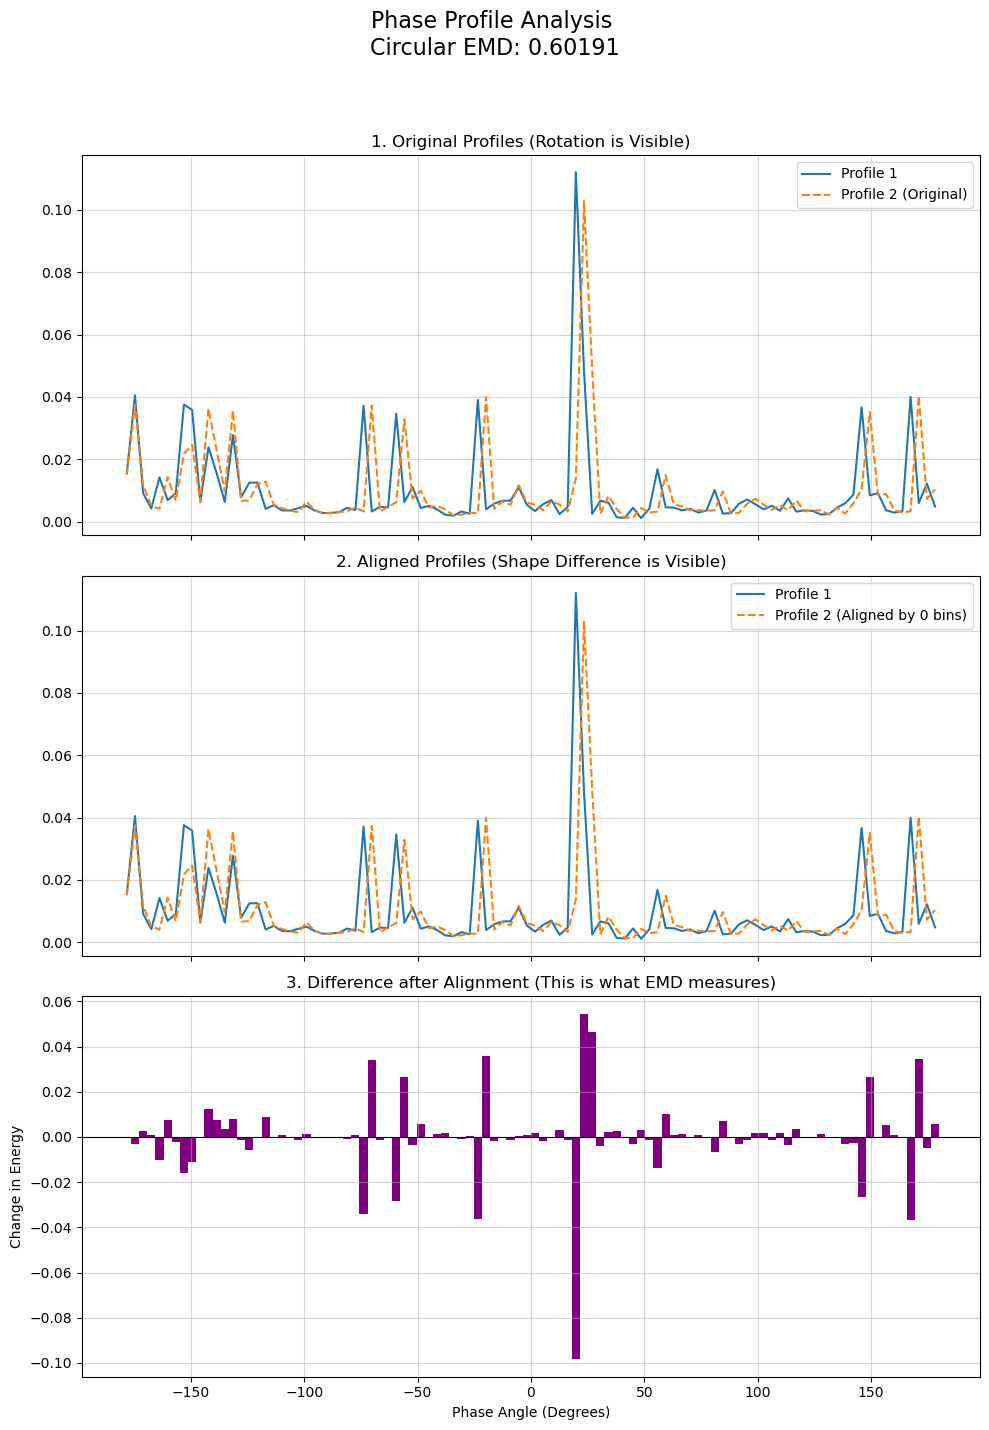

In [26]:
plot_aligned_phase_profiles(nf[0, :, :, :, 29], nf[0, :, :, :, 30])

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Assume the following functions are defined:
# - get_phase_profile
# - circular_emd_with_shift
# - num_bins

def animate_emd_inspector(fields, method="sliding"):
    """
    Creates a 3-panel diagnostic animation to visualize the circular EMD calculation
    for the kPhase metric over time.

    Parameters:
    - fields (torch.Tensor): The [166, 166, 63] complex field volume.
    - method (str): 'sliding' or 'grow'.
    """
    num_steps = fields.shape[-1]
    num_frames = num_steps - 1 if method == "sliding" else num_steps
    
    fields = torch.complex(fields[0], fields[1])

    # --- Step 1: Pre-calculate all EMD values and shifts ---
    print("Pre-calculating all EMD values and optimal shifts...")
    emd_vals = []
    shift_vals = []
    for frame in range(num_frames):
        if method == "sliding":
            field1 = fields[:, :, frame]
            field2 = fields[:, :, frame + 1]
        else: # grow
            field1 = fields[:, :, 0]
            field2 = fields[:, :, frame]

        field1_k = torch.fft.fft2(field1, norm="ortho")
        field2_k = torch.fft.fft2(field2, norm="ortho")
        device = field1_k.device
        phase_bin_edges = torch.linspace(-np.pi, np.pi, num_bins + 1, device=device)
        
        profile1 = get_phase_profile(field1_k, phase_bin_edges, num_bins).detach().cpu().numpy()
        profile2 = get_phase_profile(field2_k, phase_bin_edges, num_bins).detach().cpu().numpy()
        
        emd, shift = circular_emd_with_shift(profile1, profile2)
        emd_vals.append(emd)
        shift_vals.append(shift)
    print("Calculation complete. Starting animation rendering.")

    # --- Step 2: Set up the plot layout ---
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    bin_edges_deg = np.linspace(-180, 180, num_bins + 1)
    bin_centers_deg = (bin_edges_deg[:-1] + bin_edges_deg[1:]) / 2

    # --- Step 3: Define the animation update function ---
    def update(frame):
        # Clear all axes for the new frame
        for ax in axes:
            ax.clear()

        # Get the two fields for the current frame
        if method == "sliding":
            field1 = fields[:, :, frame]
            field2 = fields[:, :, frame + 1]
            title_text = f"Slice {frame} vs {frame+1}"
        else: # grow
            field1 = fields[:, :, 0]
            field2 = fields[:, :, frame]
            title_text = f"Slice 0 vs {frame}"

        # Generate the profiles for this frame
        field1_k = torch.fft.fft2(field1, norm="ortho")
        field2_k = torch.fft.fft2(field2, norm="ortho")
        device = field1_k.device
        phase_bin_edges = torch.linspace(-np.pi, np.pi, num_bins + 1, device=device)
        profile1_np = get_phase_profile(field1_k, phase_bin_edges, num_bins).detach().cpu().numpy()
        profile2_np = get_phase_profile(field2_k, phase_bin_edges, num_bins).detach().cpu().numpy()
        
        # Get pre-calculated values
        min_emd = emd_vals[frame]
        optimal_shift = shift_vals[frame]
        profile2_aligned = np.roll(profile2_np, shift=optimal_shift)
        
        # Update the main title
        fig.suptitle(f"EMD Inspector: {title_text}\nCircular EMD for kPhase: {min_emd:.5f}", fontsize=16)

        # Panel 1: Original Profiles
        axes[0].plot(bin_centers_deg, profile1_np, label='Profile 1')
        axes[0].plot(bin_centers_deg, profile2_np, label='Profile 2 (Original)', linestyle='--')
        axes[0].set_title("1. Original Profiles (Rotation Visible)")
        axes[0].legend(); axes[0].grid(True, alpha=0.5)

        # Panel 2: Aligned Profiles
        axes[1].plot(bin_centers_deg, profile1_np, label='Profile 1')
        axes[1].plot(bin_centers_deg, profile2_aligned, label=f'Profile 2 (Aligned)', linestyle='--')
        axes[1].set_title("2. Aligned Profiles (Shape Difference Visible)")
        axes[1].legend(); axes[1].grid(True, alpha=0.5)

        # Panel 3: Difference of Aligned Profiles
        difference = profile2_aligned - profile1_np
        axes[2].bar(bin_centers_deg, difference, width=360/num_bins, color='purple')
        axes[2].axhline(0, color='black', lw=0.8)
        axes[2].set_title("3. Difference after Alignment")
        axes[2].set_xlabel("Phase Angle (Degrees)"); axes[2].set_ylabel("Change in Energy")
        axes[2].grid(True, alpha=0.5)
        
        # Set consistent y-limits for better comparison across frames
        max_y = max(profile1_np.max(), profile2_np.max()) * 1.1
        axes[0].set_ylim(0, max_y); axes[1].set_ylim(0, max_y)
        max_diff = np.max(np.abs(difference)) * 1.1
        axes[2].set_ylim(-max_diff, max_diff)

    # --- Step 4: Create and save the animation ---
    ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=150)
    save_filename = f'../results/emd_plots/emd_inspector_animation_{method}.mp4'
    ani.save(save_filename, writer='ffmpeg', dpi=150)
    print(f"Animation saved to {save_filename}")
    plt.close()

# --- Example Usage ---
# animate_emd_inspector(fields, method="sliding")
# animate_emd_inspector(fields, method="grow")

In [28]:
animate_emd_inspector(nf[10], method="grow")

Pre-calculating all EMD values and optimal shifts...
Calculation complete. Starting animation rendering.


/tmp/ipykernel_61497/1800362469.py:111: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[2].set_ylim(-max_diff, max_diff)


Animation saved to ../results/emd_plots/emd_inspector_animation_grow.mp4


In [34]:
def normalize_fields(fields_sample):
    fields_norm = torch.zeros_like(fields_sample) # [166, 166, 63]
    num_slices = fields_sample.shape[-1]
    
    for i in range(num_slices):
        slc = fields_sample[:, :, i]
        
        total_energy = torch.linalg.norm(slc)
        fields_norm[:, :, i] = slc / (total_energy + 1e-10)
        
    return fields_norm

In [35]:
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

def animate_radial_bullseye(fields, kRadial_func):
    """
    Creates a "bullseye" animation of the k-space radial profile.
    """
    num_steps = fields.shape[-1]
    fields = torch.complex(fields[0], fields[1])
    fields = normalize_fields(fields)
    print("Pre-calculating kRadial values...")
    kRadial_vals = [kRadial_func(fields[:, :, 0], fields[:, :, i + 1]) for i in range(num_steps - 1)]
    kRadial_vals = np.array(kRadial_vals)
    print("Calculation complete. Starting animation rendering.")

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axis('off')

    # Create the ring patches (annuli) once
    h, w = fields.shape[0:2]
    max_radius = np.hypot(h/2, w/2)
    bin_edges = np.linspace(0, max_radius, num_bins + 1)
    normalized_edges = bin_edges / max_radius # Scale to fit in a [-1, 1] plot
    
    rings = []
    for i in range(num_bins):
        # Create an annulus (a wedge of 360 degrees)
        ring = patches.Wedge(center=(0, 0), r=normalized_edges[i+1], 
                              theta1=0, theta2=360, width=normalized_edges[i+1] - normalized_edges[i])
        rings.append(ring)
    
    p = PatchCollection(rings, cmap='viridis', alpha=0.9)
    ax.add_collection(p)
    fig.colorbar(p, ax=ax, label="Normalized Energy")

    def update(frame):
        field_k = torch.fft.fft2(fields[:, :, frame], norm="ortho")
        radial_bin_edges = torch.from_numpy(bin_edges).to(field_k.device)
        rho, _ = precompute_polar_coordinates(h, w, field_k.device)
        radial_profile = get_radial_profile(field_k, rho, radial_bin_edges, num_bins)
        colors = radial_profile.detach().cpu().numpy()
        
        # Normalize colors for the colormap (can be sensitive, may need adjustment)
        # Here we normalize by the max value in the current frame's profile
        if colors.max() > 0:
            colors = colors / colors.max()

        p.set_array(colors) # Update the colors of the rings
        
        if frame < len(kRadial_vals):
            title = f"Slice 0 -> {frame+1}\nkRadial EMD: {kRadial_vals[frame]:.4f}"
        else:
            title = f"Slice {frame}"
        ax.set_title(title)
        return [p]

    ani = animation.FuncAnimation(fig, update, frames=num_steps - 1, blit=True, interval=150)
    save_filename = '../results/emd_plots/radial_bullseye_animation.mp4'
    ani.save(save_filename, writer='ffmpeg', dpi=150)
    print(f"Animation saved to {save_filename}")
    plt.close()

In [36]:
num_bins = 8

animate_radial_bullseye(nf[16], kRadial)

Pre-calculating kRadial values...
Calculation complete. Starting animation rendering.
Animation saved to ../results/emd_plots/radial_bullseye_animation.mp4


In [43]:
def animate_angular_profile(fields, kAngular_func):
    """
    Creates a polar plot animation of the k-space angular profile to visualize
    the kAngular metric.
    """
    num_steps = fields.shape[-1]
    
    fields = torch.complex(fields[0], fields[1])
    fields_norm = normalize_fields(fields)
    
    # --- Step 1: Pre-calculate the kAngular metric values for the title ---
    print("Pre-calculating kAngular values...")
    kAngular_vals = [kAngular_func(fields_norm[:, :, 0], fields_norm[:, :, i + 1]) for i in range(num_steps - 1)]
    kAngular_vals = np.array(kAngular_vals)
    print("Calculation complete. Starting animation rendering.")

    # --- Step 2: Set up the plot layout ---
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    # --- Step 3: Define the animation update function ---
    def update(frame):
        ax.clear() # Clear axis for each new frame

        # Calculate the angular profile for the current frame
        field_k = torch.fft.fft2(fields_norm[:, :, frame], norm="ortho")
        h, w = field_k.shape
        device = field_k.device
        angle_bin_edges = torch.linspace(0, 2 * np.pi, num_bins + 1, device=device)
        _, theta_rad = precompute_polar_coordinates(h, w, device)
        theta_rad = (theta_rad + torch.pi) % (2 * torch.pi) # Convert to 0-2pi range for consistency
        
        # NOTE: This is a slightly modified get_angular_profile logic using radians
        angular_hist = torch.zeros(num_bins, device=device)
        for i in range(num_bins):
            mask = (theta_rad >= angle_bin_edges[i]) & (theta_rad < angle_bin_edges[i+1])
            angular_hist[i] = torch.sum(torch.abs(field_k) * torch.fft.fftshift(mask))
        
        angular_profile = angular_hist / (angular_hist.sum() + 1e-10)
        
        # Get bin centers for plotting
        bin_centers = (angle_bin_edges[:-1] + angle_bin_edges[1:]) / 2
        
        # Plot the profile as a filled area
        ax.bar(bin_centers.cpu().numpy(), angular_profile.cpu().numpy(), width=(2*np.pi/num_bins), alpha=0.7)
        ax.set_theta_zero_location("N") # 0 degrees at the top
        ax.set_theta_direction(-1) # Clockwise
        ax.set_rlabel_position(22.5)
        ax.grid(True, alpha=0.5)
        
        # Set the radial limit to be consistent across frames
        # You may need to adjust the max value based on your data
        ax.set_rlim(0, np.max(angular_profile.cpu().numpy()) * 1.5 + 0.01)

        # Update the title with the metric value for the *next* transition
        if frame < len(kAngular_vals):
            title = f"Slice 0 -> {frame+1}\nkAngular EMD: {kAngular_vals[frame]:.4f}"
        else:
            title = f"Slice {frame}"
        ax.set_title(title, va='bottom')

    # --- Step 4: Create and save the animation ---
    ani = animation.FuncAnimation(fig, update, frames=num_steps - 1, interval=150)
    save_filename = '../results/emd_plots/angular_profile_animation.mp4'
    ani.save(save_filename, writer='ffmpeg', dpi=150)
    print(f"Animation saved to {save_filename}")
    plt.close()

In [44]:
num_bins = 16

animate_angular_profile(nf[16], kAngular)

Pre-calculating kAngular values...
Calculation complete. Starting animation rendering.
Animation saved to ../results/emd_plots/angular_profile_animation.mp4
